<a href="https://colab.research.google.com/github/Viniciusp67/Consultor-de-Direito-Eleitoral/blob/main/GRU_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance prophet tensorflow scikit-learn matplotlib


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Baixar dados históricos do preço de fechamento do Ethereum até o final de 2023
end_date = '2024-06-30'
today = '2024-06-30'  # Data final para previsão
df_ethereum = yf.download('ETH-USD', '2016-01-01', end_date)
df_ethereum.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Preparar dados para Prophet e GRU
df = df_ethereum[["Date", "Adj Close"]]
df.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

<ipython-input-4-ae729887803a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)


In [5]:
# Instanciar e ajustar o modelo Prophet
model_prophet = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True
)
model_prophet.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2ldkkd46/xzws_hgy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2ldkkd46/jfy7cswt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48061', 'data', 'file=/tmp/tmp2ldkkd46/xzws_hgy.json', 'init=/tmp/tmp2ldkkd46/jfy7cswt.json', 'output', 'file=/tmp/tmp2ldkkd46/prophet_modelnhkdso1u/prophet_model-20240705195425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:54:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [6]:
# Criar um DataFrame futuro para prever os próximos 6 meses (até 30/06/2024)
future = model_prophet.make_future_dataframe(periods=(pd.to_datetime(today) - pd.to_datetime(end_date)).days)
forecast_prophet = model_prophet.predict(future)


In [7]:

# Normalizar dados
data = df['y'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)


In [8]:

# Criar conjuntos de dados para o GRU
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
look_back = 60
X, y = create_dataset(data_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Adicionar dimensão de tempo para GRU


In [9]:

# Dividir os dados em conjuntos de treino e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
# Construir o modelo GRU
model_gru = Sequential()
model_gru.add(GRU(100, return_sequences=True, input_shape=(look_back, 1)))
model_gru.add(GRU(100, return_sequences=False))
model_gru.add(Dense(25))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

In [11]:

# Adicionar early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


In [12]:

# Treinar o modelo GRU com early stopping
num_epochs = 120  # Aumente o número de épocas conforme necessário
history = model_gru.fit(X_train, y_train, batch_size=1, epochs=num_epochs, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/120
1512/1512 [==============================] - 23s 8ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 2/120
1512/1512 [==============================] - 12s 8ms/step - loss: 0.0011 - val_loss: 9.4048e-04
Epoch 3/120
1512/1512 [==============================] - 12s 8ms/step - loss: 7.2878e-04 - val_loss: 3.0232e-04
Epoch 4/120
1512/1512 [==============================] - 12s 8ms/step - loss: 7.9225e-04 - val_loss: 5.4679e-04
Epoch 5/120
1512/1512 [==============================] - 12s 8ms/step - loss: 6.5370e-04 - val_loss: 3.6919e-04
Epoch 6/120
1512/1512 [==============================] - 12s 8ms/step - loss: 7.6560e-04 - val_loss: 8.8509e-04
Epoch 7/120
1512/1512 [==============================] - 13s 8ms/step - loss: 5.3659e-04 - val_loss: 3.0276e-04
Epoch 8/120
1512/1512 [==============================] - 17s 11ms/step - loss: 5.7546e-04 - val_loss: 8.8453e-04
Epoch 9/120
1512/1512 [==============================] - 12s 8ms/step - loss: 6.5053e-04 - val_loss: 6.4413e-04
Epo

In [13]:

# Fazer previsões com o modelo GRU
train_predict = model_gru.predict(X_train)
test_predict = model_gru.predict(X_test)


15/15 [==============================] - 0s 6ms/step


In [14]:
# Inverter a normalização para obter os valores reais
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])


In [15]:

# Calcular as métricas
rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
mae = mean_absolute_error(y_test[0], test_predict[:, 0])
r2 = r2_score(y_test[0], test_predict[:, 0])


In [16]:
# Imprimir as métricas
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")


RMSE: 85.95562466630437
MAE: 62.7349897388676
R²: 0.9856261226524821


In [17]:
# Ajustar comprimento dos dados de teste e previsões
dates_test = df['ds'][train_size + look_back:]
if len(dates_test) > len(test_predict):
    dates_test = dates_test[:len(test_predict)]
elif len(test_predict) > len(dates_test):
    test_predict = test_predict[:len(dates_test)]


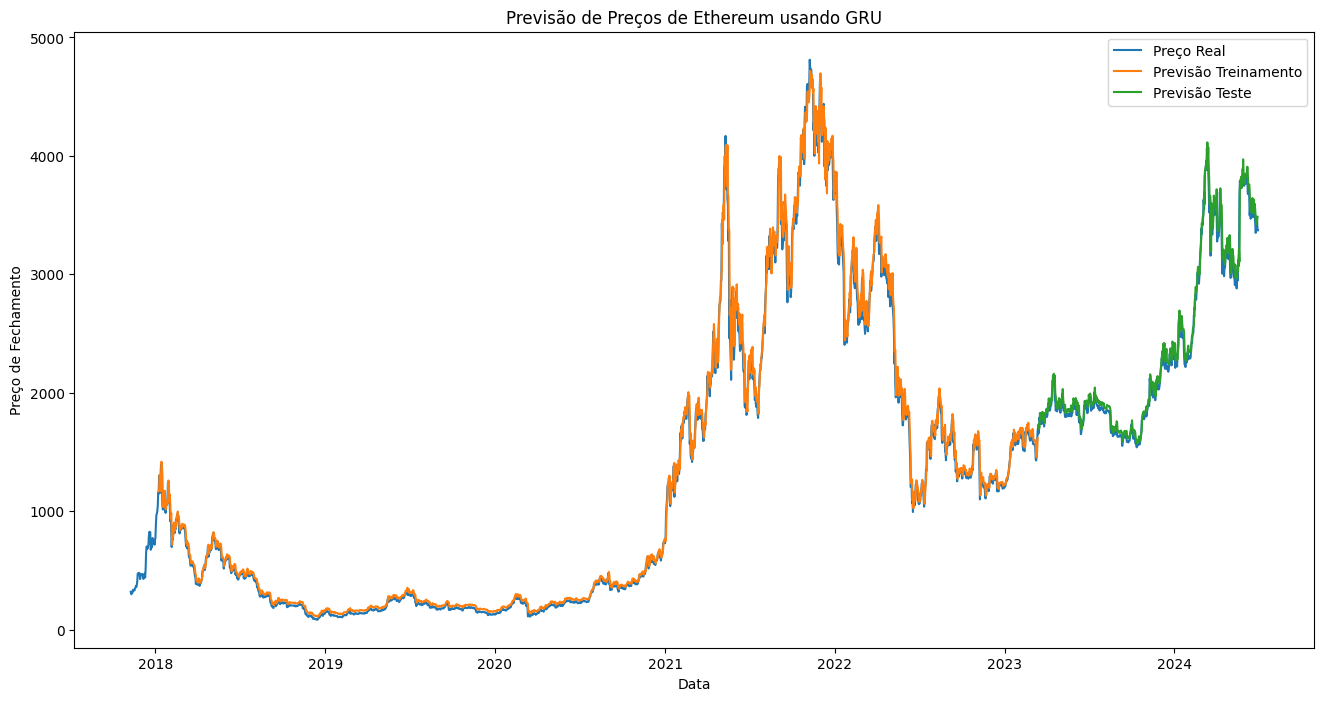

In [18]:
# Plotar os resultados
plt.figure(figsize=(16, 8))
plt.plot(df['ds'], df['y'], label='Preço Real')
plt.plot(df['ds'][look_back:train_size + look_back], train_predict, label='Previsão Treinamento')
plt.plot(dates_test, test_predict, label='Previsão Teste')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title('Previsão de Preços de Ethereum usando GRU')
plt.legend()
plt.show()

In [24]:
comparison_dates = [
    '2023-07-08', '2023-07-09', '2023-07-10',
    '2023-07-11', '2023-07-12', '2024-06-15',
    '2024-06-16', '2024-06-17', '2024-06-18',
    '2024-06-19'
]

In [25]:
# Filtrar valores reais e previsões para as datas específicas
comparison_df = df[df['ds'].isin(comparison_dates)]
comparison_predictions = forecast_prophet[forecast_prophet['ds'].isin(comparison_dates)]


In [26]:
# Montar a tabela comparativa
comparison_table = pd.DataFrame({
    'Date': comparison_df['ds'],
    'Real Value': comparison_df['y'].values,
    'Prophet Prediction': comparison_predictions['yhat'].values
})


In [27]:
# Adicionar previsões do GRU
gru_predictions = []
for date in comparison_table['Date']:
    if date in dates_test.values:
        index = dates_test[dates_test == date].index[0] - (train_size + look_back)
        if 0 <= index < len(test_predict):
            gru_predictions.append(test_predict[index][0])
        else:
            gru_predictions.append(None)
    else:
        gru_predictions.append(None)

comparison_table['GRU Prediction'] = gru_predictions

In [28]:
# Mostrar a tabela comparativa
print(comparison_table)

           Date   Real Value  Prophet Prediction  GRU Prediction
2067 2023-07-08  1865.539551         1475.769897     1910.309082
2068 2023-07-09  1863.009766         1473.541206     1910.696167
2069 2023-07-10  1880.556396         1471.988622     1902.049316
2070 2023-07-11  1878.336060         1465.904781     1925.435791
2071 2023-07-12  1872.113770         1476.750955     1915.893921
2410 2024-06-15  3565.549561         3103.134341     3526.134033
2411 2024-06-16  3620.563477         3083.010072     3637.863281
2412 2024-06-17  3511.378906         3060.383183     3644.589844
2413 2024-06-18  3483.681396         3026.617269     3603.472900
2414 2024-06-19  3559.347412         3017.451333     3516.311035
